In [2300]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import numpy as np
%matplotlib inline

# LCDM

Resolver:

$\dot \rho_i + 3(1+\gamma)H\rho_i = 0$

$H^2 = \frac{\kappa_0}{3}\sum \rho_i$

Cambiando variables, a:

$\Omega_i = \frac{\kappa_0 }{3H^2} \rho_i$ 

In [2678]:
#Condiciones iniciales
Or = 0.0001
Om = 0.3
Ol = 1. - Or - Om
H0 = 70.

In [2679]:
#Right hand side of the equations
def RHS(Omega_i, lna, gamma=0):
    x, y, z, H = Omega_i
    pi = 3*x + 4*y
    return [x*(-3 + pi), y*(-4 + pi), z*pi, -0.5*H*pi]

## Omegas

In [2680]:
y0     = [Om, Or, Ol, H0]

#Intervalo muy grande, solo para visualizacion de \Omegas
lna    = np.linspace(0, -12, 300)
result = odeint(RHS, y0, lna)

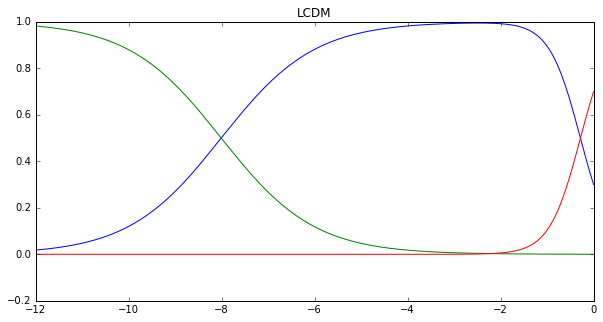

In [2681]:
plt.figure(figsize=(10,5))
for i in [0,1,2]:
    plt.plot(lna, result.T[i])
plt.title('LCDM')
plt.savefig('Omegas_LCDM.jpg')

## Hubble

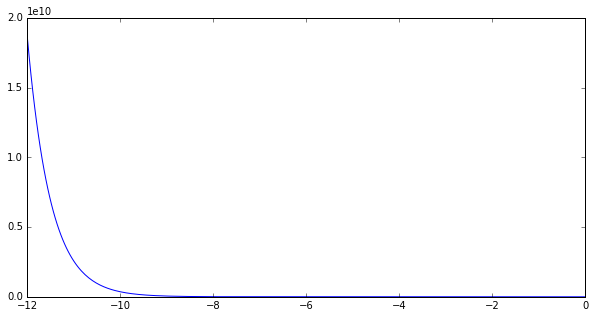

In [2624]:
plt.figure(figsize=(10,5))
plt.plot(lna, result.T[3])

In [2480]:
#Interpolando, solo en el intervalo z=[0,2]
z     = np.exp(-lna)-1.
zvals = np.linspace(0.01, 2, 300)
H_z   = np.interp(zvals, z, result.T[3])

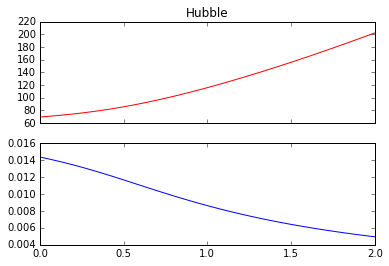

In [2617]:
plt.figure(figsize=(10,5))
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.set_title('Hubble')
ax1.plot(zvals, H_z, color ='red')
ax2.plot(zvals, 1./H_z, color ='blue')

## Data

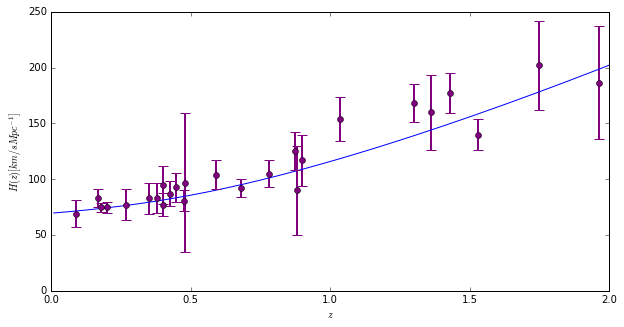

In [2616]:
plt.figure(figsize=(10,5))
plt.plot(zvals, H_z, color ='blue')
# Data
dataHz = np.loadtxt('Hz_all.dat')
redshifts, obs, errors = [dataHz[:,i] for i in [0,1,2]]
plt.errorbar(redshifts, obs, errors,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='purple', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$Datos$')
plt.xlabel(r'$z$')                            
plt.ylabel(r'$H(z) [km/s Mpc^{-1}]$') 

In [799]:
def hubble_inv(x):
    return H0/H_z[x]

In [805]:
xi = np.array([quad(hubble_inv, 0, i)[0] for i in zvals])
dl = (1+zvals)*xi
mu = 5*np.log10(dl*4000)+25 

/Users/josevazquezgonzalez/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [807]:
names = ['name', 'z', 'mu', 'error']
result = pd.read_table('sn_z_mu_dmu_union2.txt', sep='\s+', names=names, index_col='z')
result=result.sort_index()

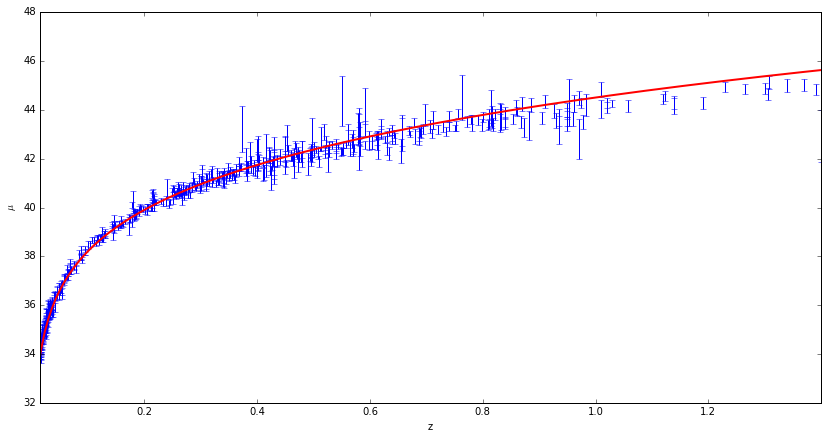

In [808]:
plt.figure(figsize=(14,7))
result['mu'].plot(yerr=result['error'], linestyle='None')
plt.plot(zvals, mu, color='red', lw=2)
plt.ylabel(r'$\mu$') 

# Campos escalares - 1er intento

In [2612]:
#Condiciones iniciales
Or0 = 0.0001
Om0 = 0.3
y0 = 0.01
x0 = np.sqrt(1. - Or - Om - y0**2)
H0 = 0.70
 

In [2613]:
#Right hand side of the equations
def RHS(Omega_i, lna, gamma=0):
    lam=40.
    Om, Or, x, y, H = Omega_i
    pi = -0.5*(3*Om + 4*Or + 6*x**2)
    return [Om*(-3 - 2*pi), Or*(-4 - 2*pi), -3*x + lam*y -x*pi, -lam*x*y -y*pi, H*pi]

In [2614]:
vec0     = [Om0, Or0, x0, y0, H0]
lna    = np.linspace(0, -5, 300)
result = odeint(RHS, vec0, lna)

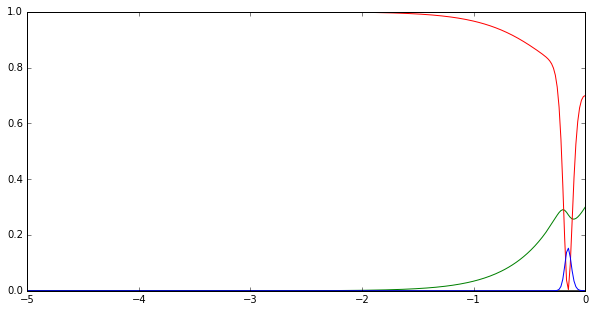

In [2615]:
plt.figure(figsize=(10,5))
plt.plot(lna, result.T[0], color='green')
plt.plot(lna, result.T[1], color='k')
plt.plot(lna, result.T[2]**2, color='red')
plt.plot(lna, result.T[3]**2, color='blue')

# Campos escalares - 2do intento

In [2650]:
from scipy.interpolate import interp1d

In [2682]:
lna = np.linspace(-12, 0, 300)
def Pot(x, i, lam=.2):
    V0=5000
    V= V0*np.exp(-lam*x)
    if i==0:
        return V
    if i==1:
        return -lam*V

In [2683]:
def hub(lna, x_vec):
    a=np.exp(lna)
    x,y= x_vec
    return np.sqrt(0.5*y**2 + Pot(x,0)/(3*H0**2) + Om0/a**3 + Or0/a**4)

def RHS(x_vec, lna):
    x, y = x_vec
    return [np.sqrt(3.0)*y/hub(lna,x_vec), -3*y -Pot(x,1)/(np.sqrt(3.)*H0*hub(lna,x_vec))]

def solver(x0, vpo):
    y0 = [x0, vpo]
    y_result = odeint(RHS, y0, lna, h0=1E-10)
    return y_result

In [2684]:
#for i in range(10):
#    a, b= solver(i,0).T
#    Ol=  (0.5*b[-1]**2+Pot(a[-1],0)/(3*H0**2))/hub(0.0, [a[-1],b[-1]])**2
#    print Ol

In [2685]:
def Ini_phi():
    lowr, highr = 0, 30
    tol, tol1 =101, 100
    Ttol= 5e-3
    count=0
                                        #search initial conditions
    if True:
        while (abs(tol)>Ttol):
            mid= (lowr+highr)/2.0
            sol = solver(mid, 0.0)
            xx, yy = sol.T
            
            Omegal=  (0.5*yy[-1]**2+Pot(xx[-1],0)/(3*H0**2))/hub(0.0, [xx[-1],yy[-1]])**2
            tol = Omegal - 0.7 # Omegal #(1.0-self.Om) - Omegal
            print Omegal, mid, tol
            if(abs(tol) < Ttol):
                #print 'reach tolerance', abs(tol), count
                break
            else:
                if(tol<0):
                    highr = mid
                else:
                    lowr = mid

            count+=1
            if (count > 30):
                print 'No solution found!'
                break
            
        #print 'mid', self.lB, self.lam, self.A
        #sol =self.solver(0., self.V0)
        print 'O_L calc', Omegal
        #self.sol =sol
        #xx, yy = sol.T
        #self.Ophi = interp1d(self.lna, (0.5*yy**2+self.Pot(xx,0)/self.Cte**2))
        #self.hubble=interp1d(self.lna, (self.hub(self.lna, sol.T))**2)
        return xx, yy

In [2686]:
xx, yy = Ini_phi()

0.0882487726406 15.0 -0.611751227359
0.443736183703 7.5 -0.256263816297
0.672181025374 3.75 -0.0278189746258
0.758073865052 1.875 0.0580738650525
0.717844401388 2.8125 0.0178444013882
0.695697055647 3.28125 -0.00430294435265
O_L calc 0.695697055647


In [2687]:
Ophi = interp1d(lna, (0.5*yy**2 + Pot(xx,0)/(3*H0**2)))
O_1 = interp1d(lna, (0.5*yy**2))
O_2 = interp1d(lna, (Pot(xx,0)/(3*H0**2)))
Hz =  hub(lna, [xx,yy])
oo = Ophi(lna) 
oo_1 = O_1(lna)
oo_2 = O_2(lna)


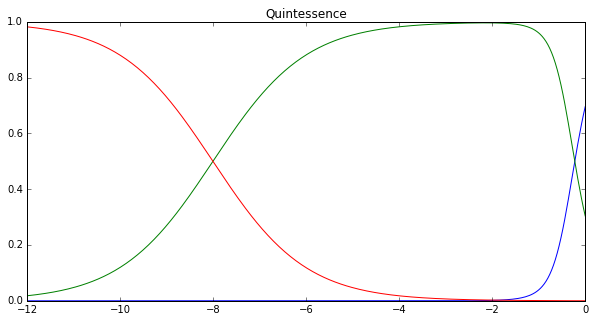

In [2688]:
plt.figure(figsize=(10,5))
plt.plot(lna, oo/hub(lna, [xx,yy])**2)
plt.plot(lna, Om0/np.exp(lna)**3/hub(lna, [xx,yy])**2)
plt.plot(lna, Or0/np.exp(lna)**4/hub(lna, [xx,yy])**2)
#for i in [0,1,2]:
#    plt.plot(lna, result_lcdm.T[i], 'o', label='LCDM')
plt.title('Quintessence')
plt.savefig('Omegas_V.jpg')

In [2689]:
v_phi = Pot(xx,0)/(3*H0**2)#/hub(lna, [xx,yy])**2
phi_dot =(0.5*yy**2)#/hub(lna, [xx,yy])**2

In [2690]:
z     = np.exp(-lna)-1.
zvals = np.linspace(0.01, 2, 100)
H_z   = np.interp(zvals, z[::-1], Hz[::-1]*70)
ipot   = np.interp(zvals, z[::-1], v_phi[::-1])
iphi_dot   = np.interp(zvals, z[::-1], phi_dot[::-1])

# Contribuciones

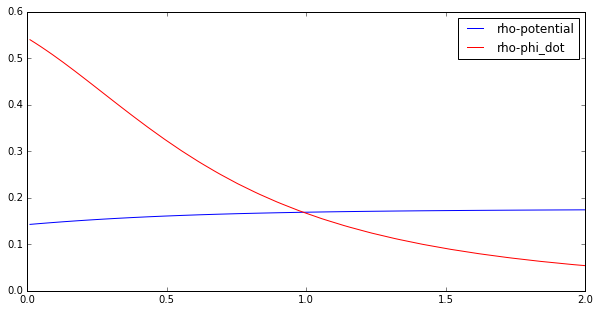

In [2691]:
plt.figure(figsize=(10,5))
plt.plot(zvals, ipot, color ='blue', label = 'rho-potential')
plt.plot(zvals, iphi_dot, color ='red', label = 'rho-phi_dot')
plt.legend()
plt.savefig('rhos_V.jpg')

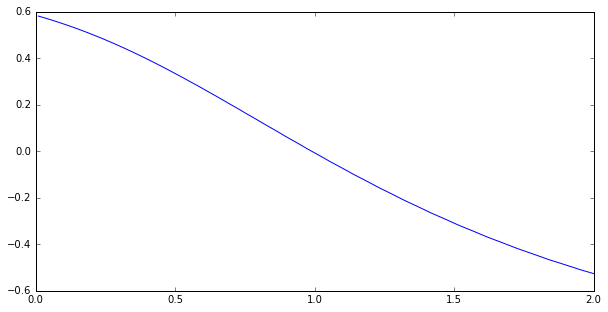

In [2674]:
plt.figure(figsize=(10,5))
plt.plot(zvals, (iphi_dot - ipot)/(iphi_dot + ipot), color ='blue', label = 'rho-potential')
#plt.plot(zvals, iphi_dot + ipot, color ='red', label = 'rho-phi_dot')
#plt.legend()
#plt.savefig('rhos.pdf')

## Doing a Forecast (simulating noise - Gaussian)

In [2675]:
noise = np.random.normal(0,5,100)

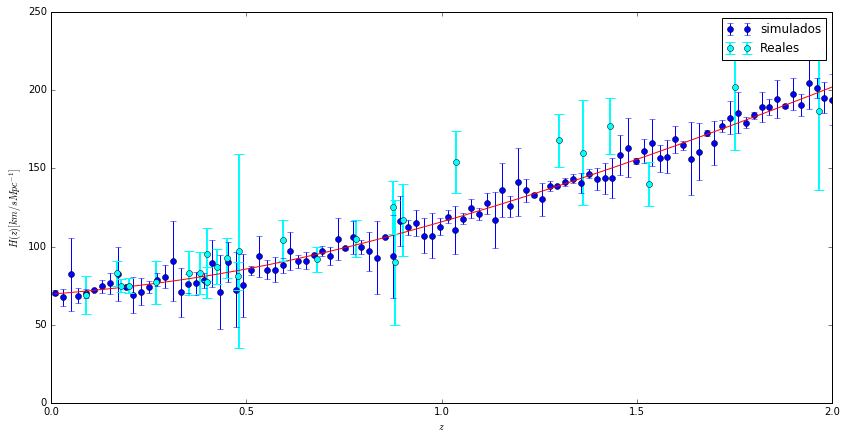

In [2692]:
plt.figure(figsize=(14,7))
plt.errorbar(zvals, H_z+noise, noise*2, marker='o', color ='blue', label = 'simulados', linestyle = 'None')
plt.plot(zvals, H_z, color ='red')#'V0 =5000, lam=0.2')
plt.xlabel(r'$z$')                            
plt.ylabel(r'$H(z) [km/s Mpc^{-1}]$') 
plt.errorbar(redshifts, obs, errors,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='cyan', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='Reales')
plt.legend()
plt.savefig('Hz_V.jpg')

## Siguiente paso: 
    * Revisar calculos
    * Sacarlo del Notebook, usar editor real